## Extracting data from sTD-xTB outputs

The output files are assumed to be `./std_xtb_run/train-*-std.out`, * being the entry number in csv. The excitation ($\Delta E_{max}$) corresponding to the experimental $\lambda_{max}$ has to be extracted from the sTD-xTB output files. We use a simple procedure—first, all peaks in the range $(\Delta E_{max}-0.8$, $\Delta E_{max}+0.5)$ are extracted, then, the peak with the highest oscillator strength among those peaks is selected. The numbers used in constructing the range are estimates from the benchmark. (In case there is no peak in the range, then the first excitation is selected.)

After data extraction, all entries where the calculated and experimental values differ by more than 100 nm are discarded. This is because such high errors can't be corrected by machine learning.

In [1]:
# data reading and processing
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt

# for MAE values
from sklearn.metrics import mean_absolute_error

In [2]:
def get_xtb_lambda(filename,range_min,range_max):
    """ Given a range of wavelengths, it extracts higest peak in eV from sTDA-xTB output """
    header_found=False
    lambda_list = [] # lambda in eV here!!!
    foscs_list = []
    with open(filename,'r') as fh:
        for line in fh:
            if not header_found:
                if line.find('state    eV      nm       fL         Rv')!=-1:
                    header_found=True
            elif line.strip()!='':
                data = line.strip().split()
                lambda_list.append(float(data[1])) ## get eV
                foscs_list.append(float(data[3])) ## get fL
            else:
                break
    lambda_list_new = np.array(lambda_list) # convert to numpy array
    foscs_list_new = np.array(foscs_list)
    my_filter = (lambda_list_new>range_min) & (lambda_list_new<range_max)
    foscs_list_new = foscs_list_new[my_filter]
    lambda_list_new = lambda_list_new[my_filter]
    if len(lambda_list_new)!=0:
        return lambda_list_new[np.argmax(foscs_list_new)]
    else: # unusual case, return the first excitation
        #abs_diff_func = lambda x : abs(x-lambda_max_val)
        #return min(lambda_list_new,key=abs_diff_func)
        return min(lambda_list)

#
def nm_to_ev(x):
    """ This function converts nm to eV and vice versa """
    return 1239.84/x

#
def plot_regression_ys(x_vals,y_vals):
    """ Takes x and y values, then returns y values for regression line"""
    x_vals = np.array(x_vals)
    y_vals = np.array(y_vals)
    slope,intercept = np.polyfit(x_vals,y_vals,1)
    return x_vals*slope+intercept

In [3]:
# data should have index, SMILES, experimental value, solvent name
train_data = pd.read_csv('../train_dataset.csv').drop('description',axis=1).rename(columns={'Unnamed: 0':'num'})
# round off to one decimal point
train_data = train_data.round({'lambda_max_exp_nm':1})
# convert to eV
train_data['abs_max_ev'] = train_data['lambda_max_exp_nm'].apply(nm_to_ev)
# populate ranges
train_data['range_min'] = train_data['abs_max_ev'].apply(lambda x: x-0.5)
train_data['range_max'] = train_data['abs_max_ev'].apply(lambda x: x+0.5)
# extract data
std_max_list = []
for i in range(len(train_data)):
    std_max_list.append(
                        get_xtb_lambda('./std_xtb_run/train-'+str(train_data.num[i])+'-std.out',
                        train_data.range_min[i],
                        train_data.range_max[i])
                       )
train_data['std_max_ev'] = std_max_list
# remove anything that has more than 1 eV difference from experiment
for i in range(len(train_data)):
    if abs(train_data.loc[i,'std_max_ev'] - train_data.loc[i,'abs_max_ev']) > 1.0:
        train_data.loc[i,'std_max_ev'] = np.nan
train_data = train_data.dropna().reset_index(drop=True)

In [4]:
# Now do the same for test dataset
test_data = pd.read_csv('../test_dataset.csv').drop('description',axis=1).rename(columns={'Unnamed: 0':'num'})
# round off to one decimal point
test_data = test_data.round({'lambda_max_exp_nm':1})
# convert to eV
test_data['abs_max_ev'] = test_data['lambda_max_exp_nm'].apply(nm_to_ev)
# populate ranges
test_data['range_min'] = test_data['abs_max_ev'].apply(lambda x: x-0.5)
test_data['range_max'] = test_data['abs_max_ev'].apply(lambda x: x+0.5)
# extract data
std_max_list = []
for i in range(len(test_data)):
    std_max_list.append(
                        get_xtb_lambda('../test/std_xtb_run/test-'+str(test_data.num[i])+'-std.out',
                        test_data.range_min[i],
                        test_data.range_max[i])
                       )
test_data['std_max_ev'] = std_max_list
# remove anything that has more than 1 eV difference from experiment
for i in range(len(test_data)):
    if abs(test_data.loc[i,'std_max_ev'] - test_data.loc[i,'abs_max_ev']) > 1.0:
        test_data.loc[i,'std_max_ev'] = np.nan
test_data = test_data.dropna().reset_index(drop=True)

In [5]:
y_train = np.array(train_data.abs_max_ev) - np.array(train_data.std_max_ev)
y_test = np.array(test_data.abs_max_ev) - np.array(test_data.std_max_ev)

Plotting the data:

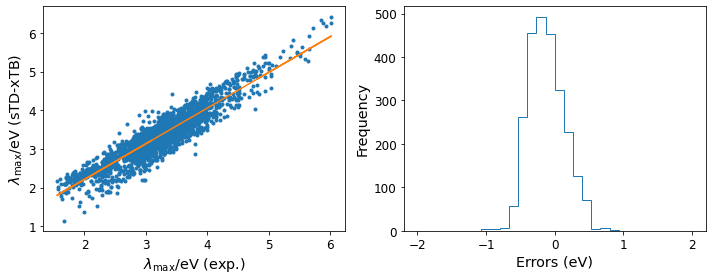

In [6]:
#plt.plot(data['lambda_max_stda'],data['lambda_max_exp_nm'],'.')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.plot(train_data.abs_max_ev,train_data.std_max_ev,'.')
ax1.plot(train_data.abs_max_ev,plot_regression_ys(train_data.abs_max_ev,train_data.std_max_ev))
ax1.set_xlabel('$\lambda_\mathrm{max}$/eV (exp.)',fontsize='x-large')
ax1.set_ylabel('$\lambda_\mathrm{max}$/eV (sTD-xTB)',fontsize='x-large')
ax1.tick_params(labelsize='large')
ax2.hist(y_train,bins=30,range=(-2,2),histtype='step')
ax2.set_xlabel('Errors (eV)',fontsize='x-large')
ax2.set_ylabel('Frequency',fontsize='x-large')
ax2.tick_params(labelsize='large')
plt.tight_layout()
plt.show()

In [7]:
print('MAE of abs. maxima wavelength from sTD-xTB vs Experimental result: %3f eV'%
      mean_absolute_error(train_data['abs_max_ev'],train_data['std_max_ev'])
     )

MAE of abs. maxima wavelength from sTD-xTB vs Experimental result: 0.235817 eV


## Preparing the models
Here we use `scikit-learn`'s linear regression, lasso, SVM regression and multi-layer perceptron regression models. The models are provided by a function which returns the average MAE from 5-fold cross-validation. This average MAE is minimised by `optuna` during hyperparameter optimisation.

In [8]:
# learning models
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# cross_validation
from sklearn.model_selection import cross_val_score

# for search space
#import skopt.space

In [9]:
def get_model(trial,m_name,X_input,y_input,std_dev_list,return_model=False):
    """ Provides an optimization function for Optuna"""
    # trial (optuna trial object) = required for optuna
    # m_name (string) = type of regression model
    # X_input (2D array)
    # y_input (1D array)
    # std_dev_list (list) = to store the standard deviations for each call
    # return_model (bool) = whether to return fitted model, or just the average cross-val error
    if m_name == 'svm': #SVR
        #kernel_val = trial.suggest_categorical('kernel_val',['rbf','poly'])
        #degree_val = trial.suggest_categorical('degree_val',[3,5])
        C_val = trial.suggest_loguniform('C_val',1e-6,1e+6)
        gamma_val = trial.suggest_loguniform('gamma_val',1e-6,1e+6)
        epsilon_val = trial.suggest_loguniform('epsilon_val',1e-3,1e+3)
        model = SVR(C=C_val,gamma=gamma_val,epsilon=epsilon_val,cache_size=300)
    elif m_name == 'rf': # random forest
        #max_depth_list.append(None)
        n_estim_val = trial.suggest_int('n_estim_val',10,100,step=10)
        max_feat_val = trial.suggest_categorical('max_feat_val',['auto','sqrt','log2'])
        max_depth_val = trial.suggest_categorical('max_depth_val',[int(x) for x in np.linspace(10,110,num=11)])
        min_samp_spl_val = trial.suggest_categorical('min_samp_spl_val',[2,5,10])
        min_samp_lf_val = trial.suggest_categorical('min_samp_lf_val',[1,2,4])
        #bootstrap_val = trial.suggest_categorical('bootstrap_val',[True,False])
        max_samp_val = trial.suggest_categorical('max_samp_val',[0.9,0.5,0.8])
        model = RandomForestRegressor(
            n_estimators=n_estim_val,
            max_features=max_feat_val,
            max_depth=max_depth_val,
            min_samples_split=min_samp_spl_val,
            min_samples_leaf=min_samp_lf_val,
            bootstrap=True,
            max_samples=max_samp_val
        )
    elif m_name == 'lasso': # Lasso
        alpha_val = trial.suggest_loguniform('alpha_val',1e-3,1000)
        model = Lasso(alpha=alpha_val,max_iter=90000,tol=0.5e-3)
    elif m_name == 'mlp': # neural network
        hidden_layer_val = trial.suggest_categorical('hidden_layer_val',[(100,),(50,100,50),(75,50,20)])
        activation_val = trial.suggest_categorical('activation_val',['tanh','relu'])
        #solver_val = trial.suggest_categorical('solver_val',['adam','lbfgs'])
        alpha_val = trial.suggest_loguniform('alpha_val',0.0001,10)
        batch_size_val = trial.suggest_categorical('batch_size_val',[64,128,'auto'])
        learning_rt_val = trial.suggest_categorical('learning_rt_val',['constant','adaptive'])
        model= MLPRegressor(
            max_iter=50000,
            #max_fun=50000,
            hidden_layer_sizes=hidden_layer_val,
            activation=activation_val,
            #solver=solver_val,
            alpha=alpha_val,
            batch_size=batch_size_val,
            learning_rate=learning_rt_val
        )
    else:
        raise ValueError('Unidentified model name!')
    if return_model:
        # in return_result mode, it returns the fitted model
        model.fit(X_input,y_input)
        return model
    else:
        # else fit the model and return data
        score = cross_val_score(model,X_input,y_input,cv=5,scoring='neg_mean_absolute_error',n_jobs=-1)
        std_dev_list.append(score.std())
        return -score.mean()

## Preparing the fingerprints
We use atom-pair fingerprint, morgan fingerprint, MACCS keys, RDK topological fingerprint from `rdkit` and descriptors from `mordred`

In [10]:
import subprocess
import random
import io
import sys
import glob

# saving and reloading expensive data
import pickle

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
#from sklearn.model_selection import cross_val_score

# for fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.AtomPairs.Pairs import GetHashedAtomPairFingerprint
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint
from rdkit.Chem.rdMolDescriptors import GetMACCSKeysFingerprint
from rdkit.Chem.rdmolops import RDKFingerprint
from mordred import Calculator, descriptors

In [11]:
%%capture
try:
    with open('mordred_selected_columns.pkl','rb') as fh:
        mordred_select_cols = pickle.load(fh)
        if len(mordred_select_cols) != 1284:
            raise Exception('Corrupted pickle file for available descriptors in Mordred')
except:
    dummy_list = []
    for dummy_file in glob.iglob('./final_xtb_opt/*.mol'):
        dummy_list.append(Chem.MolFromMolFile(dummy_file))
    for dummy_file in glob.iglob('../test/final_xtb_opt/*.mol'):
        dummy_list.append(Chem.MolFromMolFile(dummy_file))
    dummy_calc = Calculator(descriptors,ignore_3D=False)
    dummy_df = dummy_calc.pandas(dummy_list)
    # extract numerical columns that are available for all the molecules
    mordred_select_cols = list(dummy_df.select_dtypes(exclude='object').columns)
    dummy_calc = dummy_list = dummy_df = None # free up memory
    with open('mordred_selected_columns.pkl','wb') as fh:
        pickle.dump(mordred_select_cols,fh,pickle.HIGHEST_PROTOCOL)

In [12]:
solvent_to_eps = {'1,2-dichloroethane':1.4448**2, 'acetone':1.3588**2, 'acetonitrile':1.3442**2, 'benzene':1.5011**2,
       'carbon tetrachloride':1.4601**2, 'chloroform':1.4459**2, 'cyclohexane':1.4266**2,
       'dichloromethane':1.4242**2,'diethyl ether':1.3526**2, 'dimethylformamide':1.4305**2,
       'dimethylsulfoxide':1.4783**2, 'dioxane':1.4224**2,'ethanol':1.3611**2,
       'ethyl ethanoate':1.3723**2, 'hexane':1.3749**2, 'methanol':1.3288**2,'methylcyclohexane':1.4231**2,
       'n-heptane':1.3878**2, 'n-pentane':1.3575**2, 'tetrahydrofuran':1.4050**2,
       'toluene':1.4961**2, 'water':1.3328**2}

def get_fingerprint(f_name,df,test_or_train,return_unmodified=False):
    # f_name (str) = name of the fingerprint
    # df (pandas DataFrame) = dataframe containing solvent SMILES and solvent information
    # test_or_train (string) = 'test' or 'train' <= for reading the appropriate molfiles
    # return_unmodified (bool) = whether to return the unmodified array
    """ Returns the fingerprints from a pandas dataframe with a column named SMILES"""
    if not 'SMILES' in df.columns:
        raise Exception("Dataframe passed to get_fingerprint() must have 'SMILES' column")
    if not 'solvent' in df.columns:
        raise Exception("Dataframe passed to get_fingerprint() must have 'solvent' column")
    #smi_string_list = list(df.SMILES)
    if f_name == 'MORDRED':
        mols_list = []
        for index in range(len(df)):
            # read SMILES
            if test_or_train == 'train':
                filename = './final_xtb_opt/train-'+str(df.num[index])+'.mol'
            elif test_or_train == 'test':
                filename = '../test/final_xtb_opt/test-'+str(df.num[index])+'.mol'
            smi_molecule = Chem.MolFromMolFile(filename)
            #smi_molecule = Chem.AddHs(smi_molecule)
            #AllChem.EmbedMolecule(smi_molecule)
            #smi_conf = smi_molecule.GetConformer()
            # would need df.num[index]
            #mol_block = subprocess.check_output('obabel -ixyz -omol xtbopt/train-'+str(index)+'.xyz', shell=True)
            #mol = Chem.MolFromMolBlock(mol_block.decode(),removeHs=False)
            #mol_conf = mol.GetConformer()
            #for counter in range(smi_molecule.GetNumAtoms()):
            #    smi_conf.SetAtomPosition(counter,mol_conf.GetAtomPosition(counter))
            mols_list.append(smi_molecule)
        calc = Calculator(descriptors,ignore_3D=False)
        # need to suppress warnings from mordred
        prev_stdout = sys.stdout
        sys.stdout = io.StringIO()
        molprop_data = calc.pandas(mols_list)
        sys.stdout = prev_stdout
        molprop_data = molprop_data[mordred_select_cols]
        molprop_data['solvent_name'] = df.solvent.apply(lambda x: solvent_to_eps[x])
        #molprop_data = molprop_data.select_dtypes(exclude=['object'])
        init_array = molprop_data.astype(float).to_numpy()
    elif f_name == 'NOISE': # simulate a 2048-bit fingerprint
        num_list = [0,1,2,3,4,5,6,7,8,9,10,11,12] # to simulate fingerprints
        init_array = np.zeros((len(df),2049),dtype=np.float64)
        if test_or_train == 'train':
            random.seed(800)
        else: # this is to ensure same NOISE is generated everytime the model is called
            random.seed(200)
        for index in range(len(df)):
            init_array[index,:-1] = random.choices(num_list,k=2048,weights=[400,30,5,2,1,1,1,1,0.5,0.5,0.5,0.5,0.5])
            init_array[index,-1] = solvent_to_eps[df.loc[index,'solvent']]
    else:
        if f_name == 'APFP': # 2048-bit hashed APFP
            init_array = np.zeros((len(df),2049),dtype=np.float64)
            generator_func = GetHashedAtomPairFingerprint
            params = [2048]
        elif f_name == 'ECFP4': # 2048-bit hashed ECFP with radius=2
            init_array = np.zeros((len(df),2049),dtype=np.float64)
            generator_func = GetHashedMorganFingerprint
            params = [2,2048]
        elif f_name == 'ECFP6': # 2048-bit hashed ECFP with radius=3
            init_array = np.zeros((len(df),2049),dtype=np.float64)
            generator_func = GetHashedMorganFingerprint
            params = [3,2048]
        elif f_name == 'ECFP8': # 2048-bit hashed ECFP with radius=4
            init_array = np.zeros((len(df),2049),dtype=np.float64)
            generator_func = GetHashedMorganFingerprint
            params = [4,2048]
        elif f_name == 'ECFP8_4096': #4096-bit hashed ECFP with radius=4
            init_array = np.zeros((len(df),4097),dtype=np.float64)
            generator_func = GetHashedMorganFingerprint
            params = [4,4096]
        elif f_name == 'RDK': # RDK Fingerprint 2048-bit (default options)
            init_array = np.zeros((len(df),2049),dtype=np.float64)
            generator_func = RDKFingerprint
            params = [1,7,2048]
        elif f_name == 'MACCS':
            init_array = np.zeros((len(df),168),dtype=np.float64)
            generator_func = GetMACCSKeysFingerprint
            params = []
        else:
            raise Exception('Unknown fingerprint name!')
        # now generate the fingerprint
        for index in range(len(df)):
            if test_or_train == 'train':
                filename = './final_xtb_opt/train-'+str(df.num[index])+'.mol'
            elif test_or_train == 'test':
                filename = '../test/final_xtb_opt/test-'+str(df.num[index])+'.mol'
            mol = Chem.MolFromMolFile(filename)
            if mol is None:
                raise Exception('Error in reading SMILES')
            init_array[index,:-1] = list(generator_func(mol,*params))
            init_array[index,-1] = solvent_to_eps[df.loc[index,'solvent']]

    if return_unmodified:
        # return unmodified array and preprocessor
        return init_array
    else:
            # calculation done, now process the data for learning
        preprocessor = Pipeline([
        ('variance',VarianceThreshold()),
        ('scaler',StandardScaler()),
        ('pca',PCA(n_components=0.95,svd_solver='full')) #select components that explain upto 95% of variation
        #('selective_pca',ColumnTransformer(
        #    transformers=[('pca',PCA(n_components=0.95,svd_solver='full'),[x for x in range(init_array.shape[1]-1)])],
        #    remainder='passthrough')
        #) only for fingerprint not solvent epsilon
        ])
        fin_array = preprocessor.fit_transform(init_array)
        return fin_array, preprocessor

# Fitting models
The package `optuna` is used for Bayesian hyperparameter optimisation (using the default tree-of-Parzen algorithm). The best results for each model and each fingerprint are stored in pickle files. The training and hyperparameter optimisation is done on training set, then the optimised model is used on the training and the test set.

In [13]:
# optimization
import optuna

# optuna prints a lot of information messages
optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
from optuna.exceptions import ExperimentalWarning

In [14]:
fprint_type = ['APFP','ECFP4','ECFP6','ECFP8','RDK','MACCS','MORDRED','NOISE']

In [15]:
# for plotting
def running_min_val(list_of_val):
    # goes through a list taking the minimum so far
    min_vals = []
    running_min = list_of_val[0]
    min_vals.append(running_min)
    for i in list_of_val[1:]:
        if i < running_min:
            running_min = i
        min_vals.append(running_min)
    return min_vals

## Simple Linear Regression (Baseline)

In [16]:
# Show the number of variables (features) in each type of fingerprint
print('Number of features')
print('-------------------')
for fprint in fprint_type:
    print(fprint,':',get_fingerprint(fprint,train_data,'train')[0].shape[1])

Number of features
-------------------
APFP : 606
ECFP4 : 834
ECFP6 : 890
ECFP8 : 934
RDK : 562
MACCS : 78


100%|██████████████████████████████████████████████████████████████████████████████| 2492/2492 [05:52<00:00,  7.07it/s]


MORDRED : 85
NOISE : 1366


In [17]:
predictor = LinearRegression()

In [18]:
print('Average and std dev of MAEs of cross-validation (linear regression)')
print('----')
for fprint in fprint_type:
    m_score = cross_val_score(
        predictor,
        get_fingerprint(fprint,train_data,'train')[0],
        y_train,
        scoring = 'neg_mean_absolute_error',
        cv = 5,
        error_score = 'raise'
    )
    print(fprint,': %.2f (std.dev: %.2f)' % (-m_score.mean(),m_score.std()))

Average and std dev of MAEs of cross-validation (linear regression)
----
APFP : 0.26 (std.dev: 0.01)
ECFP4 : 0.22 (std.dev: 0.02)
ECFP6 : 0.20 (std.dev: 0.01)
ECFP8 : 0.20 (std.dev: 0.01)
RDK : 0.15 (std.dev: 0.00)
MACCS : 0.18 (std.dev: 0.01)


100%|██████████████████████████████████████████████████████████████████████████████| 2492/2492 [06:07<00:00,  6.79it/s]


MORDRED : 0.18 (std.dev: 0.01)
NOISE : 0.35 (std.dev: 0.01)


In [19]:
print('MAE and std. dev. on train data with linear regression')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,train_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_train))
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0] # take fitted preprocessor for training data
    predictor = LinearRegression()
    predictor.fit(X_train,y_train)# get fitted model on training data
    y_train_pred = predictor.predict(X_train)
    abs_max_pred = np.array(train_data.std_max_ev) + np.array(y_train_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(train_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on train data with linear regression
----
Before fitting : MAE = 0.236 ; std. dev. = 0.257
APFP : MAE = 0.125 ; std. dev. = 0.169
ECFP4 : MAE = 0.099 ; std. dev. = 0.135
ECFP6 : MAE = 0.100 ; std. dev. = 0.135
ECFP8 : MAE = 0.102 ; std. dev. = 0.137
RDK : MAE = 0.106 ; std. dev. = 0.144
MACCS : MAE = 0.172 ; std. dev. = 0.221


100%|██████████████████████████████████████████████████████████████████████████████| 2492/2492 [06:03<00:00,  6.86it/s]


MORDRED : MAE = 0.168 ; std. dev. = 0.216
NOISE : MAE = 0.134 ; std. dev. = 0.169


In [20]:
print('MAE and std. dev. on test data with linear regression')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,test_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_test))
for fprint in fprint_type:
    X_train, preproc = get_fingerprint(fprint,train_data,'train') # take fitted preprocessor for training data
    X_test = preproc.transform(get_fingerprint(fprint,test_data,'test',True)) # transform unmodified fingerprints
    predictor = LinearRegression()
    predictor.fit(X_train,y_train)# get fitted model on training data
    y_test_pred = predictor.predict(X_test)
    abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(test_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on test data with linear regression
----
Before fitting : MAE = 0.226 ; std. dev. = 0.261
APFP : MAE = 0.138 ; std. dev. = 0.192
ECFP4 : MAE = 0.105 ; std. dev. = 0.153
ECFP6 : MAE = 0.103 ; std. dev. = 0.139
ECFP8 : MAE = 0.108 ; std. dev. = 0.144
RDK : MAE = 0.104 ; std. dev. = 0.146
MACCS : MAE = 0.181 ; std. dev. = 0.232


100%|████████████████████████████████████████████████████████████████████████████████| 631/631 [01:28<00:00,  7.13it/s]


MORDRED : MAE = 0.169 ; std. dev. = 0.218
NOISE : MAE = 0.248 ; std. dev. = 0.311


# SVM

In [16]:
svm_best_params = {} # dict to store best params for each fingerprint
svm_error_values = {} # dict to store the error value with each trial iteration
svm_std_devs = {} # dict to store the std. deviations for each trial iteration
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0]
    svm_std_devs[fprint] = []
    wrapper_func = lambda trial : get_model(trial,'svm',X_train,y_train,svm_std_devs[fprint])
    study = optuna.create_study()
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',category=ExperimentalWarning)
        study.optimize(wrapper_func,n_trials=60,show_progress_bar=True)
    svm_best_params[fprint] = study.best_trial
    svm_error_values[fprint] = list(study.trials_dataframe()['value'])

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 2495/2495 [05:59<00:00,  6.94it/s]


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [16]:
# save into pickle
#with open('svm_results_xtb.pkl', 'wb') as fh:
#    pickle.dump((svm_best_params,svm_error_values,svm_std_devs),fh,pickle.HIGHEST_PROTOCOL)
# reload pickle if needed
#with open('svm_results_xtb.pkl', 'rb') as fh:
#    svm_best_params,svm_error_values,svm_std_devs = pickle.load(fh)#

In [24]:
print('Best MAEs of cross-validation training (SVM)')
print('----')
for fprint in fprint_type:
    min_index = np.argmin(svm_error_values[fprint])
    best_mae = svm_error_values[fprint][min_index]
    best_std = svm_std_devs[fprint][min_index]
    print(fprint,': %.3f (std.dev: %.3f)' % (best_mae,best_std))

Best MAEs of cross-validation training (SVM)
----
APFP : 0.154 (std.dev: 0.010)
ECFP4 : 0.142 (std.dev: 0.007)
ECFP6 : 0.141 (std.dev: 0.005)
ECFP8 : 0.147 (std.dev: 0.007)
RDK : 0.124 (std.dev: 0.008)
MACCS : 0.156 (std.dev: 0.006)
MORDRED : 0.152 (std.dev: 0.007)
NOISE : 0.213 (std.dev: 0.007)


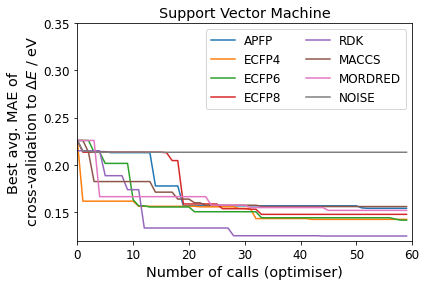

In [21]:
# For plotting
for fprint in fprint_type:
    this_running_errors = running_min_val(svm_error_values[fprint])
    plt.plot(this_running_errors,label=fprint)
plt.legend(loc='upper right',ncol=2,fontsize='large')
plt.tick_params(labelsize='large')
plt.xlim(left=0,right=60)
plt.ylim(top=0.35)
plt.xlabel('Number of calls (optimiser)',fontsize='x-large')
plt.ylabel('Best avg. MAE of\n cross-validation to $\Delta E$ / eV',fontsize='x-large')
plt.title('Support Vector Machine',fontsize='x-large')
#plt.savefig('SVM-optimisation.png',bbox_inches='tight',dpi=512)
plt.show()

In [20]:
print('MAE and std. dev. on training data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,train_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_train))
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0] # get training data (preprocessed)
    # the best parameters are passed to get_model()
    predictor = get_model(svm_best_params[fprint],'svm',X_train,y_train,[],True) # get fitted model on training data
    y_train_pred = predictor.predict(X_train)
    abs_max_pred = np.array(train_data.std_max_ev) + np.array(y_train_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(train_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on training data
----
Before fitting : MAE = 0.236 ; std. dev. = 0.257
APFP : MAE = 0.078 ; std. dev. = 0.144
ECFP4 : MAE = 0.047 ; std. dev. = 0.097
ECFP6 : MAE = 0.030 ; std. dev. = 0.085
ECFP8 : MAE = 0.081 ; std. dev. = 0.134
RDK : MAE = 0.040 ; std. dev. = 0.091
MACCS : MAE = 0.067 ; std. dev. = 0.080


100%|██████████████████████████████████████████████████████████████████████████████| 2492/2492 [05:51<00:00,  7.09it/s]


MORDRED : MAE = 0.107 ; std. dev. = 0.161
NOISE : MAE = 0.063 ; std. dev. = 0.117


In [23]:
print('MAE and std. dev. on test data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,test_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_test))
for fprint in fprint_type:
    X_train, preproc = get_fingerprint(fprint,train_data,'train') # take fitted preprocessor for training data
    X_test = preproc.transform(get_fingerprint(fprint,test_data,'test',True)) # transform unmodified fingerprints
    predictor = get_model(svm_best_params[fprint],'svm',X_train,y_train,[],True) # get fitted model on training data
    y_test_pred = predictor.predict(X_test)
    abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(test_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on test data
----
Before fitting : MAE = 0.226 ; std. dev. = 0.261
APFP : MAE = 0.089 ; std. dev. = 0.155
ECFP4 : MAE = 0.055 ; std. dev. = 0.105
ECFP6 : MAE = 0.044 ; std. dev. = 0.098
ECFP8 : MAE = 0.086 ; std. dev. = 0.131
RDK : MAE = 0.049 ; std. dev. = 0.099
MACCS : MAE = 0.079 ; std. dev. = 0.109


100%|████████████████████████████████████████████████████████████████████████████████| 631/631 [01:25<00:00,  7.34it/s]


MORDRED : MAE = 0.122 ; std. dev. = 0.176
NOISE : MAE = 0.213 ; std. dev. = 0.261


In [17]:
# ECFP6 with SVM is the best data, so we plot that
X_train, preproc = get_fingerprint('ECFP6',train_data,'train') # take fitted preprocessor for training data
X_test = preproc.transform(get_fingerprint('ECFP6',test_data,'test',True)) # transform unmodified fingerprints
predictor = get_model(svm_best_params['ECFP6'],'svm',X_train,y_train,[],True)
y_test_pred = predictor.predict(X_test)
abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)

Before fitting: MAE = 0.226
                std. dev. = 0.261
After corrections: MAE = 0.044
                   std. dev. = 0.098


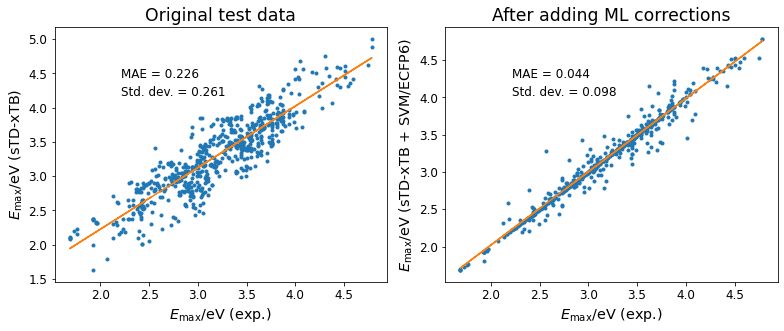

In [18]:
# print stats
MAE_before = mean_absolute_error(test_data.abs_max_ev,test_data.std_max_ev)
STD_before = np.std(y_test)
MAE_after = mean_absolute_error(test_data.abs_max_ev,abs_max_pred)
STD_after = np.std(np.array(test_data.abs_max_ev)-abs_max_pred)
print('Before fitting: MAE = %.3f'%MAE_before)
print('                std. dev. = %.3f'%STD_before)
print('After corrections: MAE = %.3f'%MAE_after)
print('                   std. dev. = %.3f'%STD_after)
# now plot the results
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11,4.7))
ax1.plot(test_data.abs_max_ev,test_data.std_max_ev,'.')
ax1.plot(test_data.abs_max_ev,plot_regression_ys(test_data.abs_max_ev,test_data.std_max_ev))
ax1.set_xlabel('$E_\mathrm{max}$/eV (exp.)',fontsize='x-large')
ax1.set_ylabel('$E_\mathrm{max}$/eV (sTD-xTB)',fontsize='x-large')
ax1.tick_params(labelsize='large')
ax1.set_title('Original test data',fontsize='xx-large')
ax1.annotate("MAE = %.3f"%MAE_before,(0.2,0.8),fontsize='large',xycoords='axes fraction')
ax1.annotate("Std. dev. = %.3f"%STD_before,(0.2,0.73),fontsize='large',xycoords='axes fraction')

ax2.plot(test_data.abs_max_ev,abs_max_pred,'.')
ax2.plot(test_data.abs_max_ev,plot_regression_ys(test_data.abs_max_ev,abs_max_pred))
ax2.set_xlabel('$E_\mathrm{max}$/eV (exp.)',fontsize='x-large')
ax2.set_ylabel('$E_\mathrm{max}$/eV (sTD-xTB + SVM/ECFP6)',fontsize='x-large')
ax2.tick_params(labelsize='large')
ax2.set_title('After adding ML corrections',fontsize='xx-large')
ax2.annotate("MAE = %.3f"%MAE_after,(0.2,0.8),fontsize='large',xycoords='axes fraction')
ax2.annotate("Std. dev. = %.3f"%STD_after,(0.2,0.73),fontsize='large',xycoords='axes fraction')
plt.tight_layout()
#plt.savefig('SVM-ECFP6-eV.png',bbox_inches='tight',dpi=512)
plt.show()

### Analysis of outliers

In [22]:
import rdkit.Chem.Draw
from rdkit import DataStructs
# pick the outliers from SVM/ECFP6
test_data['svm_ecfp6_pred'] = abs_max_pred
test_data['diff_svm_exp'] = test_data.svm_ecfp6_pred - test_data.abs_max_ev
# sort according to the difference and then select the top 20 with the highest errors and get their SMILES
outliers = test_data[abs(test_data.diff_svm_exp)>0.2].copy().sort_values('diff_svm_exp',ascending=False).iloc[:20]
smi_outliers = list(outliers.sort_values('diff_svm_exp',ascending=False).iloc[:20].SMILES)
mols_outliers = [Chem.MolFromSmiles(x) for x in smi_outliers]

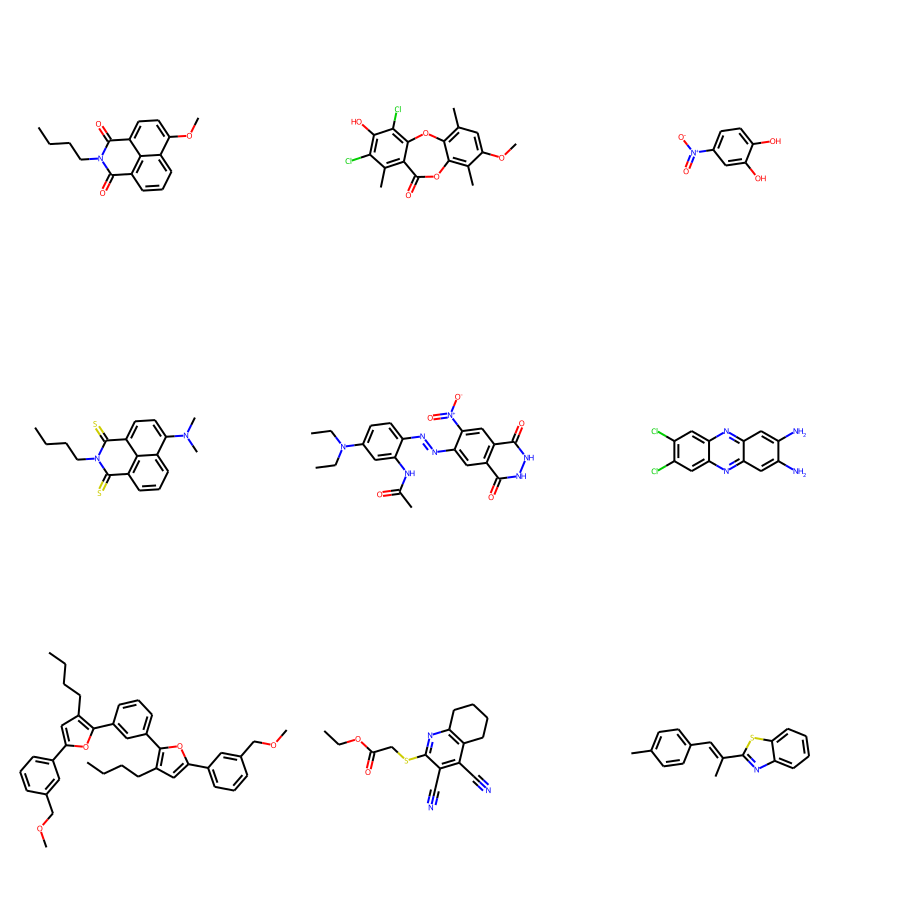

In [21]:
# draw 9 outliers
rdkit.Chem.Draw.MolsToGridImage(mols_outliers[:9],subImgSize=(300,300)) # => can't see any trend ???

In [41]:
smi_outliers

['CCCCN1C(=O)c2cccc3c(OC)ccc(c23)C1=O',
 'COc1cc(C)c2c(c1C)OC(=O)c1c(C)c(Cl)c(O)c(Cl)c1O2',
 'O=[N+]([O-])c1ccc(O)c(O)c1',
 'CCCCN1C(=S)c2cccc3c(N(C)C)ccc(c23)C1=S',
 'CCN(CC)c1ccc(/N=N/c2cc3c(=O)[nH][nH]c(=O)c3cc2[N+](=O)[O-])c(NC(C)=O)c1',
 'Nc1cc2nc3cc(Cl)c(Cl)cc3nc2cc1N',
 'CCCCc1cc(-c2cccc(COC)c2)oc1-c1cccc(-c2oc(-c3cccc(COC)c3)cc2CCCC)c1',
 'CCOC(=O)CSc1nc2c(c(C#N)c1C#N)CCCC2',
 'C/C(=C\\c1ccc(C)cc1)c1nc2ccccc2s1',
 'CCN(CC)c1ccc(-c2nc(Oc3ccc(-c4nc5ccc(Cl)cc5o4)cc3)nc(Oc3ccc(-c4nc5ccc(Cl)cc5o4)cc3)n2)cc1',
 'C/C(=C\\c1ccc(Cl)cc1)c1nc2ccccc2s1',
 'N#C/C(=C\\c1ccc(Cl)cc1)c1nc2ccccc2s1',
 'O=[N+]([O-])c1ccccc1O',
 'Nc1nc2ccc(F)cc2[n+]([O-])n1',
 'Oc1ccccc1-c1nc2c(c3c1-c1ccccc1CC3)-c1ccccc1CC2',
 'Oc1cccc(/N=C/c2ccccc2Oc2ccccc2)c1',
 'Cc1cc(C)nc(N)n1',
 'F[B-]1(F)OC(c2ccccc2)=C(c2ccccc2)c2sc3ccccc3[n+]21',
 'CCNc1ccc2c(C(F)(F)F)cc(=O)oc2c1',
 'O=c1oc2ccccc2nc1-c1ccc(Cl)cc1']

In [42]:
similarity_array = np.zeros((len(mols_outliers),len(mols_outliers)),dtype=np.float64)
for i in range(similarity_array.shape[0]):
    for j in range(similarity_array.shape[1]):
        fp_a = GetHashedMorganFingerprint(mols_outliers[i],3)
        fp_b = GetHashedMorganFingerprint(mols_outliers[j],3)
        similarity_array[i,j] = DataStructs.DiceSimilarity(fp_a,fp_b)
pd.DataFrame(similarity_array)

## Lasso

In [16]:
lasso_best_params = {} # dict to store best params for each fingerprint
lasso_error_values = {} # dict to store the error value with each trial iteration
lasso_std_devs = {} # dict to store the std. deviations for each trial iteration
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0]
    lasso_std_devs[fprint] = []
    wrapper_func = lambda trial : get_model(trial,'lasso',X_train,y_train,lasso_std_devs[fprint])
    study = optuna.create_study()
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',category=ExperimentalWarning)
        study.optimize(wrapper_func,n_trials=60,show_progress_bar=True)
    lasso_best_params[fprint] = study.best_trial
    lasso_error_values[fprint] = list(study.trials_dataframe()['value'])

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 2495/2495 [05:59<00:00,  6.94it/s]


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [26]:
# save
#with open('lasso_results_xtb.pkl', 'wb') as fh:
#    pickle.dump((lasso_best_params,lasso_error_values,lasso_std_devs),fh,pickle.HIGHEST_PROTOCOL)
# reload
#with open('lasso_results_xtb.pkl', 'rb') as fh:
#    lasso_best_params,lasso_error_values,lasso_std_devs = pickle.load(fh)

In [27]:
print('Best MAEs of cross-validation training (Lasso)')
print('----')
for fprint in fprint_type:
    min_index = np.argmin(lasso_error_values[fprint])
    best_mae = lasso_error_values[fprint][min_index]
    best_std = lasso_std_devs[fprint][min_index]
    print(fprint,': %.3f (std.dev: %.3f)' % (best_mae,best_std))

Best MAEs of cross-validation training (Lasso)
----
APFP : 0.173 (std.dev: 0.008)
ECFP4 : 0.158 (std.dev: 0.005)
ECFP6 : 0.156 (std.dev: 0.004)
ECFP8 : 0.161 (std.dev: 0.008)
RDK : 0.146 (std.dev: 0.005)
MACCS : 0.184 (std.dev: 0.008)
MORDRED : 0.179 (std.dev: 0.009)
NOISE : 0.214 (std.dev: 0.006)


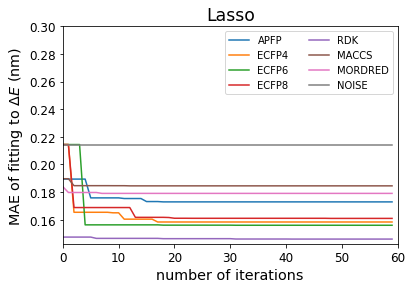

In [28]:
# For plotting
for fprint in fprint_type:
    this_running_errors = running_min_val(lasso_error_values[fprint])
    plt.plot(this_running_errors,label=fprint)
plt.legend(loc='upper right',ncol=2)
plt.tick_params(labelsize='large')
plt.xlim(left=0,right=60)
plt.ylim(top=0.3)
plt.xlabel('number of iterations',fontsize='x-large')
plt.ylabel('MAE of fitting to $\Delta E$ (nm)',fontsize='x-large')
plt.title('Lasso',fontsize='xx-large')
plt.show()

In [29]:
print('MAE and std. dev. on training data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,train_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_train))
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0] # get training data (preprocessed)
    # the best parameters are passed to get_model()
    predictor = get_model(lasso_best_params[fprint],'lasso',X_train,y_train,[],True) #get fitted model on training data
    y_train_pred = predictor.predict(X_train)
    abs_max_pred = np.array(train_data.std_max_ev) + np.array(y_train_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(train_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on training data
----
Before fitting : MAE = 0.236 ; std. dev. = 0.257
APFP : MAE = 0.137 ; std. dev. = 0.183
ECFP4 : MAE = 0.119 ; std. dev. = 0.159
ECFP6 : MAE = 0.121 ; std. dev. = 0.162
ECFP8 : MAE = 0.128 ; std. dev. = 0.171
RDK : MAE = 0.115 ; std. dev. = 0.154
MACCS : MAE = 0.173 ; std. dev. = 0.222


100%|██████████████████████████████████████████████████████████████████████████████| 2492/2492 [06:03<00:00,  6.85it/s]


MORDRED : MAE = 0.168 ; std. dev. = 0.216
NOISE : MAE = 0.207 ; std. dev. = 0.257


In [30]:
print('MAE and std. dev. on test data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,test_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_test))
for fprint in fprint_type:
    X_train, preproc = get_fingerprint(fprint,train_data,'train') # take fitted preprocessor for training data
    X_test = preproc.transform(get_fingerprint(fprint,test_data,'test',True)) # transform unmodified fingerprints
    predictor = get_model(lasso_best_params[fprint],'lasso',X_train,y_train,[],True) #get fitted model on training dat
    y_test_pred = predictor.predict(X_test)
    abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(test_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on test data
----
Before fitting : MAE = 0.226 ; std. dev. = 0.261
APFP : MAE = 0.145 ; std. dev. = 0.190
ECFP4 : MAE = 0.118 ; std. dev. = 0.161
ECFP6 : MAE = 0.119 ; std. dev. = 0.157
ECFP8 : MAE = 0.126 ; std. dev. = 0.167
RDK : MAE = 0.110 ; std. dev. = 0.151
MACCS : MAE = 0.182 ; std. dev. = 0.231


100%|████████████████████████████████████████████████████████████████████████████████| 631/631 [01:20<00:00,  7.83it/s]


MORDRED : MAE = 0.169 ; std. dev. = 0.218
NOISE : MAE = 0.211 ; std. dev. = 0.261


## Multi-Layer Perceptron

In [18]:
mlp_best_params = {} # dict to store best params for each fingerprint
mlp_error_values = {} # dict to store the error value with each trial iteration
mlp_std_devs = {} # dict to store the std. deviations for each trial iteration
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0]
    mlp_std_devs[fprint] = []
    wrapper_func = lambda trial : get_model(trial,'mlp',X_train,y_train,mlp_std_devs[fprint])
    study = optuna.create_study()
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',category=ExperimentalWarning)
        warnings.filterwarnings(action='ignore',message='Choices for a categorical distribution should be a tuple')
        study.optimize(wrapper_func,n_trials=60,show_progress_bar=True)
    mlp_best_params[fprint] = study.best_trial
    mlp_error_values[fprint] = list(study.trials_dataframe()['value'])

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 2495/2495 [06:01<00:00,  6.90it/s]


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [31]:
# save
#with open('mlp_results_xtb.pkl', 'wb') as fh:
#    pickle.dump((mlp_best_params,mlp_error_values,mlp_std_devs),fh,pickle.HIGHEST_PROTOCOL)
# reload
#with open('mlp_results_xtb.pkl', 'rb') as fh:
#    mlp_best_params,mlp_error_values,mlp_std_devs = pickle.load(fh)

In [32]:
print('Best MAEs of cross-validation training (MLP)')
print('----')
for fprint in fprint_type:
    min_index = np.argmin(mlp_error_values[fprint])
    best_mae = mlp_error_values[fprint][min_index]
    best_std = mlp_std_devs[fprint][min_index]
    print(fprint,': %.3f (std.dev: %.3f)' % (best_mae,best_std))

Best MAEs of cross-validation training (MLP)
----
APFP : 0.156 (std.dev: 0.009)
ECFP4 : 0.144 (std.dev: 0.008)
ECFP6 : 0.143 (std.dev: 0.006)
ECFP8 : 0.149 (std.dev: 0.007)
RDK : 0.133 (std.dev: 0.008)
MACCS : 0.155 (std.dev: 0.008)
MORDRED : 0.151 (std.dev: 0.009)
NOISE : 0.214 (std.dev: 0.007)


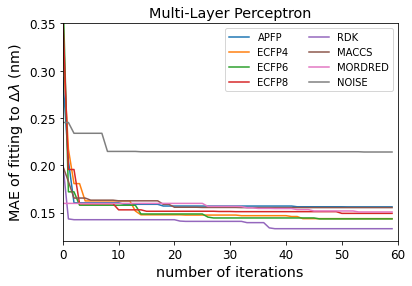

In [33]:
# For plotting
for fprint in fprint_type:
    this_running_errors = running_min_val(mlp_error_values[fprint])
    plt.plot(this_running_errors,label=fprint)
plt.legend(loc='upper right',ncol=2)
plt.tick_params(labelsize='large')
plt.xlim(left=0,right=60)
plt.ylim(top=0.35)
plt.xlabel('number of iterations',fontsize='x-large')
plt.ylabel('MAE of fitting to $\Delta \lambda$ (nm)',fontsize='x-large')
plt.title('Multi-Layer Perceptron',fontsize='x-large')
plt.show()

In [34]:
print('MAE and std. dev. on training data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,train_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_train))
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0] # get training data (preprocessed)
    # the best parameters are passed to get_model()
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',message='Choices for a categorical distribution should be a tuple')
        predictor = get_model(mlp_best_params[fprint],'mlp',X_train,y_train,[],True) # get fitted model
    y_train_pred = predictor.predict(X_train)
    abs_max_pred = np.array(train_data.std_max_ev) + np.array(y_train_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(train_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on training data
----
Before fitting : MAE = 0.236 ; std. dev. = 0.257
APFP : MAE = 0.112 ; std. dev. = 0.156
ECFP4 : MAE = 0.084 ; std. dev. = 0.115
ECFP6 : MAE = 0.085 ; std. dev. = 0.120
ECFP8 : MAE = 0.084 ; std. dev. = 0.119
RDK : MAE = 0.076 ; std. dev. = 0.108
MACCS : MAE = 0.105 ; std. dev. = 0.138


100%|██████████████████████████████████████████████████████████████████████████████| 2492/2492 [05:50<00:00,  7.11it/s]


MORDRED : MAE = 0.101 ; std. dev. = 0.134
NOISE : MAE = 0.207 ; std. dev. = 0.257


In [35]:
print('MAE and std. dev. on test data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,test_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_test))
for fprint in fprint_type:
    X_train, preproc = get_fingerprint(fprint,train_data,'train') # take fitted preprocessor for training data
    X_test = preproc.transform(get_fingerprint(fprint,test_data,'test',True)) # transform unmodified fingerprints
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',message='Choices for a categorical distribution should be a tuple')
        predictor = get_model(mlp_best_params[fprint],'mlp',X_train,y_train,[],True) #get fitted model on training dat
    y_test_pred = predictor.predict(X_test)
    abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(test_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on test data
----
Before fitting : MAE = 0.226 ; std. dev. = 0.261
APFP : MAE = 0.121 ; std. dev. = 0.167
ECFP4 : MAE = 0.092 ; std. dev. = 0.135
ECFP6 : MAE = 0.089 ; std. dev. = 0.126
ECFP8 : MAE = 0.088 ; std. dev. = 0.123
RDK : MAE = 0.079 ; std. dev. = 0.115
MACCS : MAE = 0.106 ; std. dev. = 0.144


100%|████████████████████████████████████████████████████████████████████████████████| 631/631 [01:20<00:00,  7.84it/s]


MORDRED : MAE = 0.106 ; std. dev. = 0.144
NOISE : MAE = 0.211 ; std. dev. = 0.261


## Random Forest

In [20]:
rf_best_params = {} # dict to store best params for each fingerprint
rf_error_values = {} # dict to store the error value with each trial iteration
rf_std_devs = {} # dict to store the std. deviations for each trial iteration
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0]
    rf_std_devs[fprint] = []
    wrapper_func = lambda trial : get_model(trial,'rf',X_train,y_train,rf_std_devs[fprint])
    study = optuna.create_study()
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',category=ExperimentalWarning)
        study.optimize(wrapper_func,n_trials=60,show_progress_bar=True)
    rf_best_params[fprint] = study.best_trial
    rf_error_values[fprint] = list(study.trials_dataframe()['value'])

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 2495/2495 [06:19<00:00,  6.58it/s]


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [36]:
# save
#with open('rf_results_xtb.pkl', 'wb') as fh:
#    pickle.dump((rf_best_params,rf_error_values,rf_std_devs),fh,pickle.HIGHEST_PROTOCOL)
# reload
#with open('rf_results_xtb.pkl','rb') as fh:
#    rf_best_params,rf_error_values,rf_std_devs = pickle.load(fh)

In [37]:
print('Best MAEs of cross-validation training (RF)')
print('----')
for fprint in fprint_type:
    min_index = np.argmin(rf_error_values[fprint])
    best_mae = rf_error_values[fprint][min_index]
    best_std = rf_std_devs[fprint][min_index]
    print(fprint,': %.3f (std.dev: %.3f)' % (best_mae,best_std))

Best MAEs of cross-validation training (RF)
----
APFP : 0.173 (std.dev: 0.007)
ECFP4 : 0.167 (std.dev: 0.006)
ECFP6 : 0.172 (std.dev: 0.005)
ECFP8 : 0.176 (std.dev: 0.006)
RDK : 0.149 (std.dev: 0.007)
MACCS : 0.161 (std.dev: 0.006)
MORDRED : 0.163 (std.dev: 0.006)
NOISE : 0.214 (std.dev: 0.006)


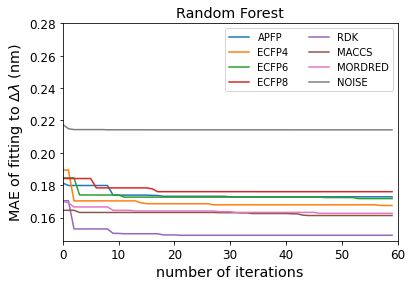

In [38]:
# For plotting
for fprint in fprint_type:
    this_running_errors = running_min_val(rf_error_values[fprint])
    plt.plot(this_running_errors,label=fprint)
plt.legend(loc='upper right',ncol=2)
plt.tick_params(labelsize='large')
plt.xlim(left=0,right=60)
plt.ylim(top=0.28)
plt.xlabel('number of iterations',fontsize='x-large')
plt.ylabel('MAE of fitting to $\Delta \lambda$ (nm)',fontsize='x-large')
plt.title('Random Forest',fontsize='x-large')
plt.show()

In [39]:
print('MAE and std. dev. on training data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,train_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_train))
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0] # get training data (preprocessed)
    # the best parameters are passed to get_model()
    predictor = get_model(rf_best_params[fprint],'rf',X_train,y_train,[],True) # get fitted model
    y_train_pred = predictor.predict(X_train)
    abs_max_pred = np.array(train_data.std_max_ev) + np.array(y_train_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(train_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on training data
----
Before fitting : MAE = 0.236 ; std. dev. = 0.257
APFP : MAE = 0.079 ; std. dev. = 0.106
ECFP4 : MAE = 0.067 ; std. dev. = 0.090
ECFP6 : MAE = 0.074 ; std. dev. = 0.099
ECFP8 : MAE = 0.071 ; std. dev. = 0.094
RDK : MAE = 0.061 ; std. dev. = 0.084
MACCS : MAE = 0.069 ; std. dev. = 0.092


100%|██████████████████████████████████████████████████████████████████████████████| 2492/2492 [06:11<00:00,  6.71it/s]


MORDRED : MAE = 0.069 ; std. dev. = 0.093
NOISE : MAE = 0.128 ; std. dev. = 0.161


In [40]:
print('MAE and std. dev. on test data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,test_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_test))
for fprint in fprint_type:
    X_train, preproc = get_fingerprint(fprint,train_data,'train') # take fitted preprocessor for training data
    X_test = preproc.transform(get_fingerprint(fprint,test_data,'test',True)) # transform unmodified fingerprints
    predictor = get_model(rf_best_params[fprint],'rf',X_train,y_train,[],True) #get fitted model on training data
    y_test_pred = predictor.predict(X_test)
    abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(test_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on test data
----
Before fitting : MAE = 0.226 ; std. dev. = 0.261
APFP : MAE = 0.094 ; std. dev. = 0.127
ECFP4 : MAE = 0.080 ; std. dev. = 0.113
ECFP6 : MAE = 0.088 ; std. dev. = 0.121
ECFP8 : MAE = 0.089 ; std. dev. = 0.121
RDK : MAE = 0.076 ; std. dev. = 0.107
MACCS : MAE = 0.085 ; std. dev. = 0.121


100%|████████████████████████████████████████████████████████████████████████████████| 631/631 [01:22<00:00,  7.63it/s]


MORDRED : MAE = 0.085 ; std. dev. = 0.119
NOISE : MAE = 0.214 ; std. dev. = 0.264


## Testing SVM/ECFP6 with training set size

The original training set contains 2500 samples (some of them are discarded during the initial sTD-xTB data collection). Here, we test whether removing some data from the training set reduces its efficiency on the testing set.

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, preproc = get_fingerprint('ECFP6',train_data,'train')
X_test = preproc.transform(get_fingerprint('ECFP6',test_data,'test',True))
X_train_part = X_train.copy()
y_train_part = y_train.copy()
MAE_with_loss = {} # dict to store MAE for number of training samples
for i in range(25):
    # we use the best hyperparameters from previous optimisation
    predictor = get_model(svm_best_params['ECFP6'],'svm',X_train_part,y_train_part,[],True) #get fitted model
    y_test_pred = predictor.predict(X_test)
    abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)
    MAE_with_loss[X_train_part.shape[0]] = mean_absolute_error(test_data.abs_max_ev,abs_max_pred)
    # lose 10% of the training dataset
    X_train_part, dummy0, y_train_part, dummy1 = train_test_split(X_train_part,y_train_part,test_size=0.1)

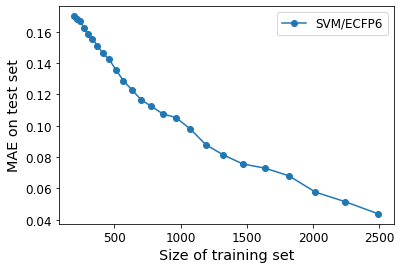

In [28]:
plt.plot(MAE_with_loss.keys(),MAE_with_loss.values(),'o-',label='SVM/ECFP6')
plt.xlabel('Size of training set',fontsize='x-large')
plt.ylabel('MAE on test set',fontsize='x-large')
plt.tick_params(labelsize='large')
plt.legend(loc='upper right',fontsize='large')
#plt.savefig('SVM-ECFP6-loss-graph.png',bbox_inches='tight',dpi=512)

## Testing feature importance with RF/MACCS

In [16]:
X_train = get_fingerprint('MACCS',train_data,'train',True) # get unmodified MACCS
study = optuna.create_study()
wrapper_func = lambda trial : get_model(trial,'rf',X_train,y_train,[])
study = optuna.create_study()
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore',category=ExperimentalWarning)
    study.optimize(wrapper_func,n_trials=60,show_progress_bar=True)

  0%|          | 0/60 [00:00<?, ?it/s]

In [17]:
print(study.best_trial.params)

{'n_estim_val': 100, 'max_feat_val': 'auto', 'max_depth_val': 90, 'min_samp_spl_val': 2, 'min_samp_lf_val': 1, 'max_samp_val': 0.9}


In [18]:
X_test = get_fingerprint('MACCS',test_data,'test',True)
predictor = get_model(study.best_trial,'rf',X_train,y_train,[],True) #get fitted model on training data
y_test_pred = predictor.predict(X_test)
abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)
print('MACCS + RF',': MAE on test data = %.3f'%mean_absolute_error(test_data.abs_max_ev,abs_max_pred))

MACCS + RF : MAE on test data = 0.070


The MAE is quite good, but not as good as SVM/ECFP6 of course. Now we determine the importances of different MACCS positions.

In [19]:
# This cell calculates Gini impurity based results, which aren't very interpretable
#importances = predictor.feature_importances_
#feat_names = np.array([str(i) for i in range(167)]+['solvent_epsilon'])
#sorted_indices = np.argsort(importances)[-10:] # choose 10 most important features
#plt.barh(feat_names[sorted_indices],importances[sorted_indices],height=0.7,color='dimgrey')
#plt.tick_params(labelsize='large')
#plt.xlabel('Impurity based feature importance',fontsize='x-large')
#plt.ylabel('MACCS position number',fontsize='x-large')
#plt.savefig('RF-MACCS-importance.png')
#plt.show()

In [20]:
import shap
X_train_pd = pd.DataFrame(X_train)
predictor = get_model(study.best_trial,'rf',X_train_pd,y_train,[],True) #get fitted model on training data
explainer = shap.Explainer(predictor)

In [21]:
named_X = pd.DataFrame(X_test,columns=['MACCS #'+str(x) for x in range(167)]+['solvent_epsilon'])
shap_values = explainer(named_X)

In [24]:
print(shap_values.base_values[0])
#with open('shapley_save','wb') as fh:
#    pickle.dump(shap_values,fh,pickle.HIGHEST_PROTOCOL)
#with open('shapley_save','rb') as fh:
#    shap_values = pickle.load(fh)

[-0.11811016]


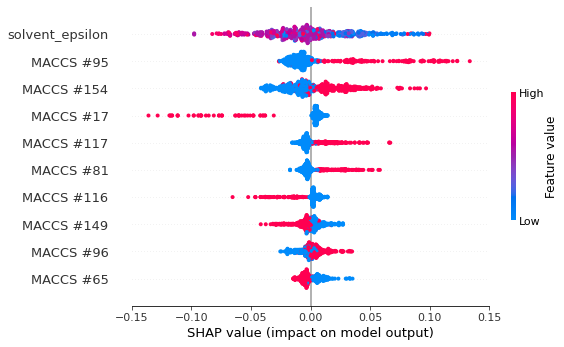

In [66]:
shap.summary_plot(shap_values,named_X,max_display=10,plot_type='dot',show=False)
plt.gcf().axes[-1].set_aspect(30)
plt.gcf().axes[-1].set_box_aspect(70)
plt.xlim(left=-0.15,right=0.15)
#plt.savefig('shapley-RF-MACCS.png',bbox_inches='tight',dpi=512)
plt.show()

## Testing fitted model on FRET dyes

In [16]:
fret_df = pd.read_csv('charmm_dyes/charmm_dye_list.csv')
init_X_test = np.zeros((len(fret_df),2049),dtype=np.float64)
for index in range(len(fret_df)):
    # read mols
    mol = Chem.MolFromMolFile('charmm_dyes/xtbopt/'+str(fret_df.loc[index,'description'])+'-xtbopt.mol')
    init_X_test[index,:-1] = list(GetHashedMorganFingerprint(mol,3,nBits=2048))
    init_X_test[index,-1] = 1.3328**2

In [25]:
X_train, preproc = get_fingerprint('ECFP6',train_data,'train')
X_test = preproc.transform(init_X_test)
predictor = get_model(svm_best_params['ECFP6'],'svm',X_train,y_train,[],True) #get fitted model on training data
y_test_pred = predictor.predict(X_test)
abs_max_pred = np.array(fret_df.std_max_ev) + np.array(y_test_pred)
fret_df['std_ml_pred'] = abs_max_pred
print('Before fitting: MAE = %.3f'%mean_absolute_error(fret_df.abs_max_ev,fret_df.std_max_ev))
print('ECFP6',': MAE = %.3f'%mean_absolute_error(fret_df.abs_max_ev,abs_max_pred),end='')
#print(' std. dev. = %.3f'%np.std(np.array(fret_df.abs_max_ev)-abs_max_pred))

Before fitting: MAE = 0.414
ECFP6 : MAE = 0.335

In [22]:
fret_df

,SMILES,lambda_max_exp_nm,description,charge,abs_max_ev,std_max_ev,std_ml_pred
0,CC1(C)C2=CC(=CC=C2[N+](CCCCS([O-])(=O)=O)=C1\C...,633,alexa647,-3,1.959,2.375,2.260446
1,CC1CC(C)(C)NC2=CC3=C(C=C12)C(=C1C=C2C(C)CC(C)(...,554,atto550,1,2.238,2.593,2.584542
2,CCN1C2=CC3=C(C=C2C(C)CC1(C)C)C(C1=CC=CC=C1C(=O...,646,atto647n,1,1.919,2.346,2.215341
3,CN1C2=C(C=CC=C2)C(C)(C)\C1=C\C=C\C1=[N+](CCCCC...,554,cy3,1,2.238,2.495,2.287002
4,CNC(=O)CC1=CC2=C(C=C1)N1CCC3OC4CC[N+]5=C(C4=CC...,559,cy3b,0,2.218,2.522,2.571905
5,CN1C2=C(C=CC=C2)C(C)(C)\C1=C\C=C\C=C\C1=[N+](C...,649,cy5,1,1.910,2.404,2.296379
6,CN1C2=C(C=CC=C2)C(C)(C)\C1=C/C=C1\CCCC(\C=C\C2...,743,cy7,1,1.669,2.314,2.280148
